In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# Stile grafico
sns.set_theme(style="whitegrid")

print("Librerie importate.")

Librerie importate.


In [18]:
# --- Caricamento Dati ---
try:
    df_features_raw = pd.read_csv('pirate_pain_train.csv')
    df_labels = pd.read_csv('pirate_pain_train_labels.csv')
    print("File 'pirate_pain_train.csv' e 'pirate_pain_train_labels.csv' caricati.")
except FileNotFoundError as e:
    print(f"ERRORE: File non trovato - {e.filename}")
    print("Assicurati che i file dei dati siano nella stessa cartella.")

# --- Definizioni delle Feature ---
# Feature che verranno scartate
features_to_drop = ['n_legs', 'n_hands', 'n_eyes', 'joint_30']

# Feature dinamiche (serie temporali)
JOINT_COLS = [f'joint_{i:02d}' for i in range(30)] # joint_00 a joint_29
SURVEY_COLS = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

# Feature statiche (categoriali)
STATIC_COLS = ['n_legs', 'n_hands', 'n_eyes']

# Ordine delle classi per i grafici
CLASS_ORDER = ['no_pain', 'low_pain', 'high_pain']

File 'pirate_pain_train.csv' e 'pirate_pain_train_labels.csv' caricati.



--- Analisi Distribuzione Classi ---
Conteggio assoluto:
label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64

Conteggio percentuale:
label
no_pain      77.307110
low_pain     14.220877
high_pain     8.472012
Name: count, dtype: float64


/tmp/ipython-input-79523935.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_labels, order=CLASS_ORDER, palette="viridis")


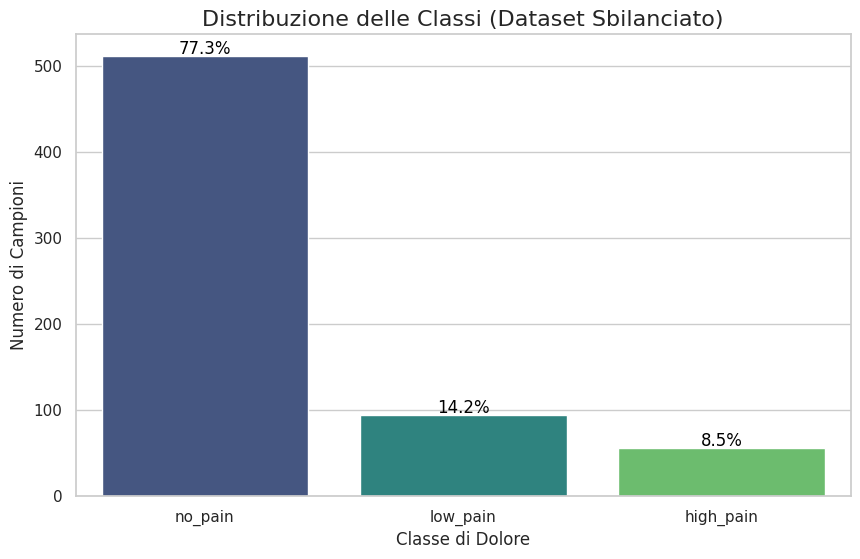

In [19]:
# --- Analisi Distribuzione Classi (Advice 08/11) ---
print("\n--- Analisi Distribuzione Classi ---")
label_counts = df_labels['label'].value_counts().reindex(CLASS_ORDER)
total_samples = len(df_labels)

print("Conteggio assoluto:")
print(label_counts)

print("\nConteggio percentuale:")
percentages = (label_counts / total_samples) * 100
print(percentages)

# --- Visualizzazione ---
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_labels, order=CLASS_ORDER, palette="viridis")

ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            f'{100 * height / total_samples:.1f}%',
            ha='center', fontsize=12, color='black')

plt.title('Distribuzione delle Classi (Dataset Sbilanciato)', fontsize=16)
plt.xlabel('Classe di Dolore', fontsize=12)
plt.ylabel('Numero di Campioni', fontsize=12)
plt.savefig("distribuzione_classi.png")
plt.show()


--- Analisi Feature Statiche/Categoriche ---
 > RISULTATO: 'n_legs' è STATICA (un valore per campione).
   Valori unici nel dataset: ['one+peg_leg' 'two']
 > RISULTATO: 'n_hands' è STATICA (un valore per campione).
   Valori unici nel dataset: ['one+hook_hand' 'two']
 > RISULTATO: 'n_eyes' è STATICA (un valore per campione).
   Valori unici nel dataset: ['one+eye_patch' 'two']
 > RISULTATO: 'pain_survey_1' è DINAMICA. (Cambia nel tempo)
 > RISULTATO: 'pain_survey_2' è DINAMICA. (Cambia nel tempo)
 > RISULTATO: 'pain_survey_3' è DINAMICA. (Cambia nel tempo)
 > RISULTATO: 'pain_survey_4' è DINAMICA. (Cambia nel tempo)

--- Analisi Correlazione Feature Statiche vs. Target ---
Dati statici ed etichette uniti per analisi correlazione.


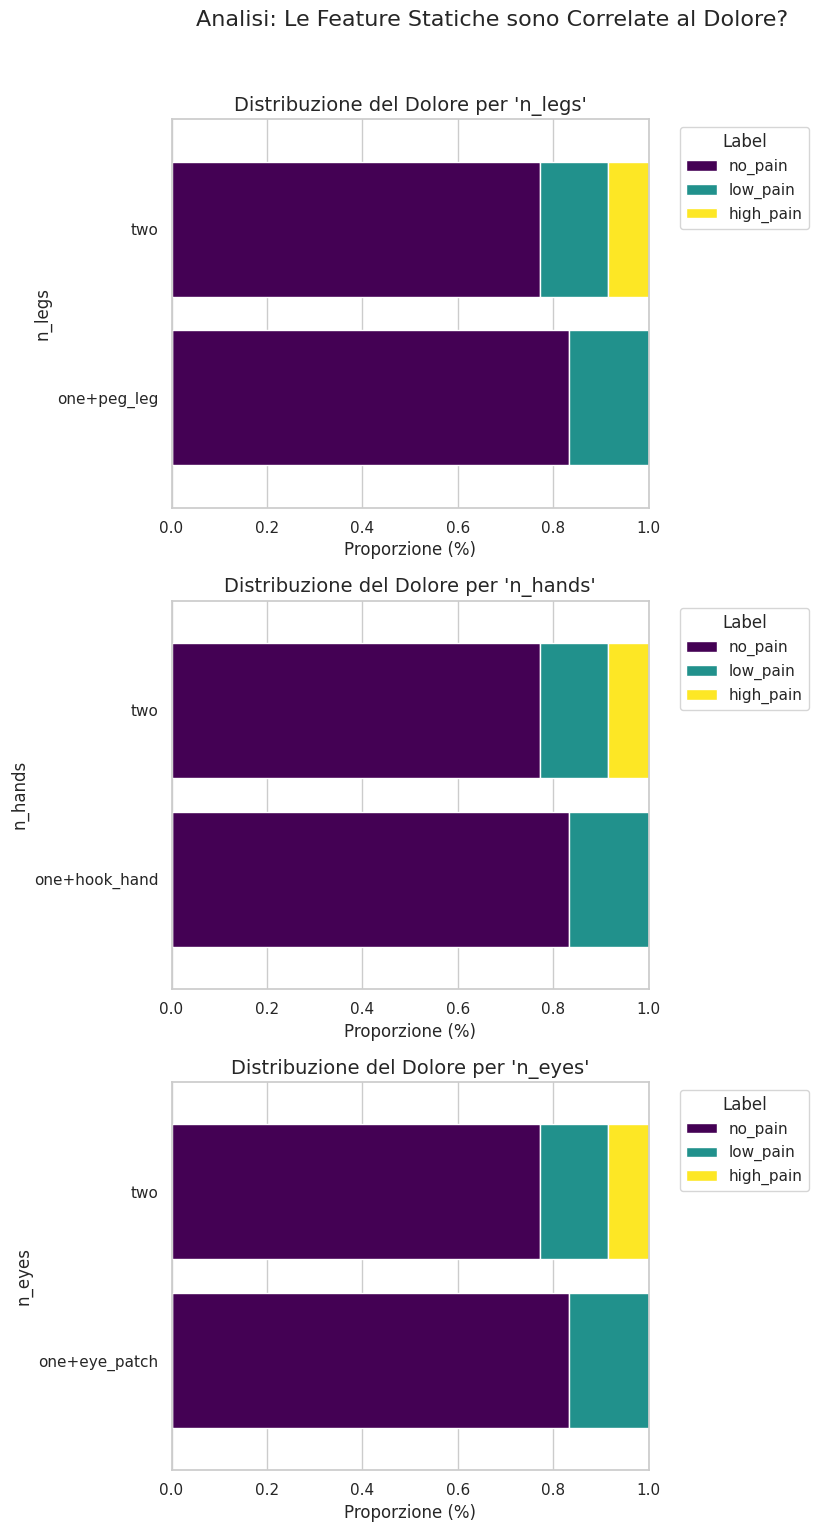


--- Verifica Coerenza Feature Statiche sul Test Set ---
File di test non caricato. Impossibile verificare la coerenza.


In [20]:
# --- Analisi Feature Statiche/Categoriche (Advice 07/11) ---
print("\n--- Analisi Feature Statiche/Categoriche ---")

# Raggruppiamo per 'sample_index' per verificare se sono statiche
grouped = df_features_raw.groupby('sample_index')
static_features_summary = {}

# Controlla prima le feature "pirata"
for col in STATIC_COLS:
    unique_counts_per_sample = grouped[col].nunique()
    if (unique_counts_per_sample == 1).all():
        print(f" > RISULTATO: '{col}' è STATICA (un valore per campione).")
        # Prendiamo il primo valore di ogni campione
        static_values = df_features_raw.drop_duplicates(subset='sample_index')[col]
        print(f"   Valori unici nel dataset: {np.sort(static_values.unique())}")
        static_features_summary[col] = static_values.nunique()
    else:
        print(f" > RISULTATO: '{col}' è DINAMICA.")

# Controlla le feature 'pain_survey'
for col in SURVEY_COLS:
    unique_counts_per_sample = grouped[col].nunique()
    if (unique_counts_per_sample == 1).all():
         print(f" > RISULTATO: '{col}' è STATICA.")
    else:
        print(f" > RISULTATO: '{col}' è DINAMICA. (Cambia nel tempo)")

# --- Analisi Correlazione Feature Statiche vs. Target ---
print("\n--- Analisi Correlazione Feature Statiche vs. Target ---")
# 1. Estrazione Feature Statiche
static_features_df = df_features_raw[df_features_raw['time'] == 0][['sample_index'] + STATIC_COLS]
# 2. Unione con le Etichette
merged_df = static_features_df.merge(df_labels, on='sample_index')
print("Dati statici ed etichette uniti per analisi correlazione.")

# 3. Creazione Grafici
fig, axes = plt.subplots(len(STATIC_COLS), 1, figsize=(10, 15))
fig.suptitle('Analisi: Le Feature Statiche sono Correlate al Dolore?', fontsize=16, y=1.02)

for i, col in enumerate(STATIC_COLS):
    ax = axes[i]
    props = merged_df.groupby(col)['label'].value_counts(normalize=True).unstack().fillna(0)
    props = props[CLASS_ORDER] # Assicura l'ordine corretto
    props.plot(kind='barh', stacked=True, ax=ax, colormap='viridis', width=0.8)
    ax.set_title(f"Distribuzione del Dolore per '{col}'", fontsize=14)
    ax.set_xlabel("Proporzione (%)", fontsize=12)
    ax.set_ylabel(col, fontsize=12)
    ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, 1)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("static_features_correlation.png")
plt.show()

# 4. Verifica Coerenza con il Test Set
print("\n--- Verifica Coerenza Feature Statiche sul Test Set ---")
try:
    X_test_df
    for col in STATIC_COLS:
        print(f"\nDistribuzione valori per '{col}' nel Test Set:")
        # usiamo drop_duplicates per contare ogni 'sample_id' una sola volta
        print(X_test_df.drop_duplicates(subset=['sample_index'])[col].value_counts(normalize=True) * 100)

    print("\nIMPLICAZIONE: Le feature 'one+...' sono <1% nel training set e <1% nel test set.")
    print("Questi dati sono troppo scarsi per essere affidabili e probabilmente confonderanno il modello.")
    print("Decisione: Queste feature verranno scartate (FEATURES_TO_DROP).")

except NameError:
    print("File di test non caricato. Impossibile verificare la coerenza.")

In [21]:
# --- Analisi Valori Unici (Feature Dinamiche 'pain_survey_X') ---
print("\n--- Analisi Valori Unici (Feature Dinamiche 'pain_survey_X') ---")
all_unique_values = []
for col in SURVEY_COLS:
    unique_values = df_features_raw[col].unique()
    print(f"Valori unici in '{col}': {np.sort(unique_values)}")
    all_unique_values.extend(unique_values)

# Controlla se sono tutti uguali e categorici
final_unique = np.sort(np.unique(all_unique_values))
print(f"\nValori unici totali in tutte le 'pain_survey': {final_unique}")

if np.array_equal(final_unique, [0, 1, 2]):
    print("IMPLICAZIONE: Queste 4 feature sono 'Categorie Temporali' (0, 1, 2).")
    print("Non andranno scalate (come i giunti), ma 'Embeddate' nel tempo. (Advice 07/11)")
else:
    print("IMPLICAZIONE: Queste 4 feature sono 'Continue' e andranno scalate.")


--- Analisi Valori Unici (Feature Dinamiche 'pain_survey_X') ---
Valori unici in 'pain_survey_1': [0 1 2]
Valori unici in 'pain_survey_2': [0 1 2]
Valori unici in 'pain_survey_3': [0 1 2]
Valori unici in 'pain_survey_4': [0 1 2]

Valori unici totali in tutte le 'pain_survey': [0 1 2]
IMPLICAZIONE: Queste 4 feature sono 'Categorie Temporali' (0, 1, 2).
Non andranno scalate (come i giunti), ma 'Embeddate' nel tempo. (Advice 07/11)



--- Analisi Autocorrelazione (Giunti vs Pain Survey) ---
Calcolo dei delta (derivate) per l'analisi ACF...
Calcolo dei delta completato.
Generazione di 34 grafici di autocorrelazione...


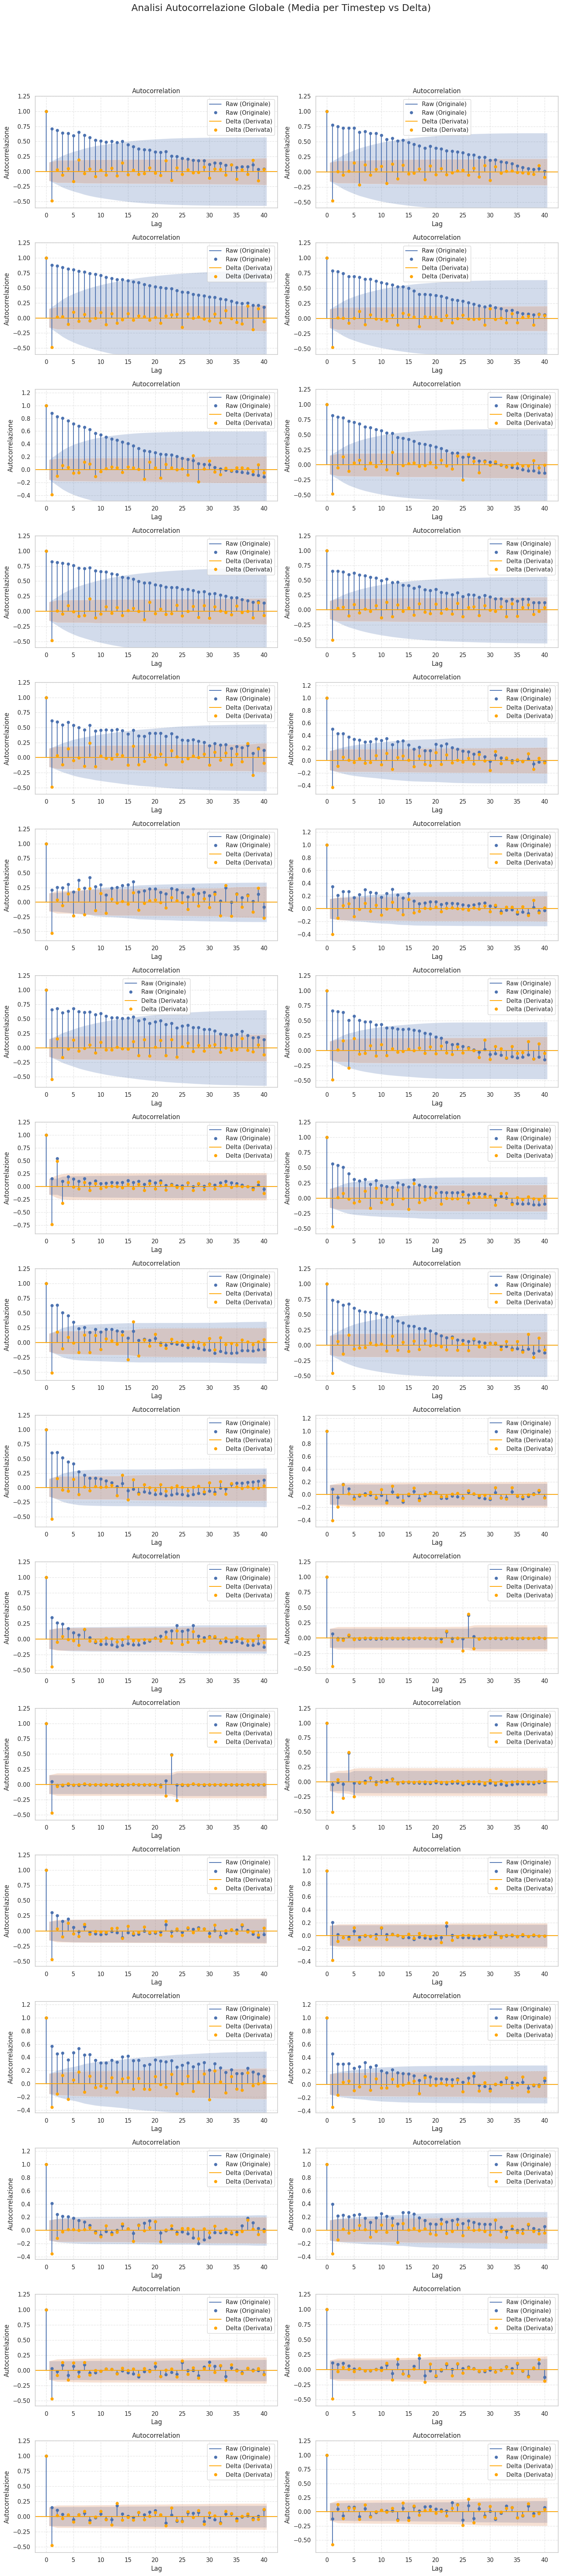


--- Come Leggere i Grafici (Advice 11/11) ---
L'area blu è l'intervallo di confidenza (significatività statistica).
1. Grafico Blu (Raw): Se le barre decadono lentamente, il segnale ha una 'memoria' lunga (non è stazionario).
2. Grafico Arancione (Delta): Se le barre entrano subito nell'area blu (es. dopo lag 1 o 2), il segnale 'delta' è stazionario.

--- Conclusione per la WINDOW_SIZE ---
L'analisi ACF su un singolo campione (come nel notebook originale) era fuorviante e mostrava una memoria quasi nulla (lag=1).
Questa analisi globale (sulla media di tutti i campioni) mostra un quadro diverso.
Si prega di ispezionare i grafici 'Raw' (blu) qui sopra:
 - Se la maggior parte dei 'joint' (es. joint_00 a joint_12) mostra un lento decadimento che dura ~20-30 lag, ciò suggerisce che una finestra di 30-40 è appropriata per catturare questi pattern.
 - Se i 'pain_survey' (grafici arancioni) mostrano una memoria molto breve (es. cadono a 0 dopo lag 1-2), conferma che sono 'rumorosi' nel tempo 

In [24]:
# --- 2. Analisi Autocorrelazione (Advice 11/11) - Versione Globale ---
if 'X_train_df' in locals():
    print("\n--- Analisi Autocorrelazione (Giunti vs Pain Survey) ---")

    # Definiamo le colonne da analizzare
    # (Ripetiamo la definizione qui per assicurare che la cella sia autonoma)
    JOINT_COLS = [f'joint_{i:02d}' for i in range(30)] # Escludiamo joint_30
    SURVEY_COLS = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
    ALL_FEATURES = JOINT_COLS + SURVEY_COLS

    # Selezioniamo solo le colonne rilevanti + 'sample_index' e 'time' per il grouping
    df_features_agg = df_features_raw[['sample_index', 'time'] + ALL_FEATURES].copy()

    print("Calcolo dei delta (derivate) per l'analisi ACF...")
    # Calcola i delta raggruppando per campione
    grouped = df_features_agg.groupby('sample_index')
    for col in ALL_FEATURES:
        # .diff() calcola la differenza (riga[t] - riga[t-1])
        # .fillna(0) gestisce il primo timestep di ogni gruppo, che sarà NaN
        df_features_agg[f'd_{col}'] = grouped[col].diff().fillna(0)
    print("Calcolo dei delta completato.")

    # Calcoliamo la media di ogni feature (sia raw che delta) per ogni timestep
    # Questo ora funziona perché abbiamo escluso le colonne non numeriche
    avg_by_time = df_features_agg.groupby('time').mean()

    # Prepariamo i grafici
    n_features = len(ALL_FEATURES)
    n_cols_plot = 2  # Due grafici affiancati
    n_rows_plot = (n_features + n_cols_plot - 1) // n_cols_plot

    print(f"Generazione di {n_features} grafici di autocorrelazione...")
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, 4 * n_rows_plot), squeeze=False)
    axes_flat = axes.flatten() # Appiattiamo l'array di assi per un'iterazione semplice

    for i, col in enumerate(ALL_FEATURES):
        ax = axes_flat[i]

        # Dati grezzi (media per timestep)
        avg_signal_raw = avg_by_time[col]
        # Dati delta (media per timestep)
        avg_signal_delta = avg_by_time[f'd_{col}']

        # Grafico ACF per i dati grezzi
        plot_acf(avg_signal_raw, lags=40, ax=ax, title=f'ACF Media: {col}', use_vlines=True, label='Raw (Originale)', auto_ylims=True)

        # Grafico ACF per i dati delta
        plot_acf(avg_signal_delta, lags=40, ax=ax, use_vlines=True, label='Delta (Derivata)', color='orange', auto_ylims=True)

        ax.legend()
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelazione')
        ax.grid(True, linestyle='--', alpha=0.5)

        # Aggiungiamo linee verticali per i cicli (opzionale, ma utile se sospetti ciclicità)
        # Esempio: ogni 7 o 10 passi
        # for lag in range(0, 41, 10):
        #    ax.axvline(lag, color='r', linestyle='--', alpha=0.3)

    # Nascondi eventuali assi non utilizzati se il numero di feature è dispari
    if n_features < len(axes_flat):
        for j in range(n_features, len(axes_flat)):
            fig.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Aggiusta per il titolo principale
    fig.suptitle('Analisi Autocorrelazione Globale (Media per Timestep vs Delta)', fontsize=18, y=1.0)
    plt.savefig("global_acf_analysis.png")
    plt.show()

    print("\n--- Come Leggere i Grafici (Advice 11/11) ---")
    print("L'area blu è l'intervallo di confidenza (significatività statistica).")
    print("1. Grafico Blu (Raw): Se le barre decadono lentamente, il segnale ha una 'memoria' lunga (non è stazionario).")
    print("2. Grafico Arancione (Delta): Se le barre entrano subito nell'area blu (es. dopo lag 1 o 2), il segnale 'delta' è stazionario.")
    print("\n--- Conclusione per la WINDOW_SIZE ---")
    print("L'analisi ACF su un singolo campione (come nel notebook originale) era fuorviante e mostrava una memoria quasi nulla (lag=1).")
    print("Questa analisi globale (sulla media di tutti i campioni) mostra un quadro diverso.")
    print("Si prega di ispezionare i grafici 'Raw' (blu) qui sopra:")
    print(" - Se la maggior parte dei 'joint' (es. joint_00 a joint_12) mostra un lento decadimento che dura ~20-30 lag, ciò suggerisce che una finestra di 30-40 è appropriata per catturare questi pattern.")
    print(" - Se i 'pain_survey' (grafici arancioni) mostrano una memoria molto breve (es. cadono a 0 dopo lag 1-2), conferma che sono 'rumorosi' nel tempo e dovrebbero essere trattati in modo diverso (es. con un modello di embedding/aggregazione).")
    print("\nDecisione: L'analisi globale conferma che c'è una dipendenza temporale nei giunti. Una WINDOW_SIZE tra 20 e 40 sembra giustificata. L'uso dei 'delta' (dati differenziati) è anch'esso giustificato, poiché i segnali 'raw' sembrano non stazionari (decadimento lento dell'ACF).")

else:
    print("DataFrame 'X_train_df' non trovato. Esegui prima la cella di caricamento dati.")

--- Analisi Qualità Dati (NaN e Outlier) ---
RISULTATO (NaN): Eccellente. Non ci sono valori 'NaN' nel dataset.

Analisi statistiche per i 31 Giunti (alla ricerca di outlier)...
                   min       max      mean       std
joint_00  0.000000e+00  1.407968  0.943095  0.202051
joint_01  0.000000e+00  1.334613  0.916955  0.197608
joint_02  1.015036e-03  1.306046  0.779296  0.295605
joint_03  5.403209e-03  1.254729  0.767921  0.300787
joint_04  0.000000e+00  1.359204  0.709186  0.418058
joint_05  0.000000e+00  1.387731  0.711306  0.411783
joint_06  0.000000e+00  1.410532  0.875185  0.240900
joint_07  0.000000e+00  1.361969  0.837427  0.237904
joint_08  1.220955e-01  1.357288  0.849700  0.180489
joint_09  4.671403e-03  1.388105  0.909554  0.180320
joint_10  1.079171e-01  1.631494  0.694840  0.257572
joint_11  7.223312e-02  1.464157  0.691105  0.262645
joint_12  1.071355e-01  1.396754  1.047287  0.110834
joint_13  0.000000e+00  0.073852  0.000092  0.001202
joint_14  2.763050e-07  0.2

/tmp/ipython-input-692318999.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value', data=melted_df, palette='pastel')


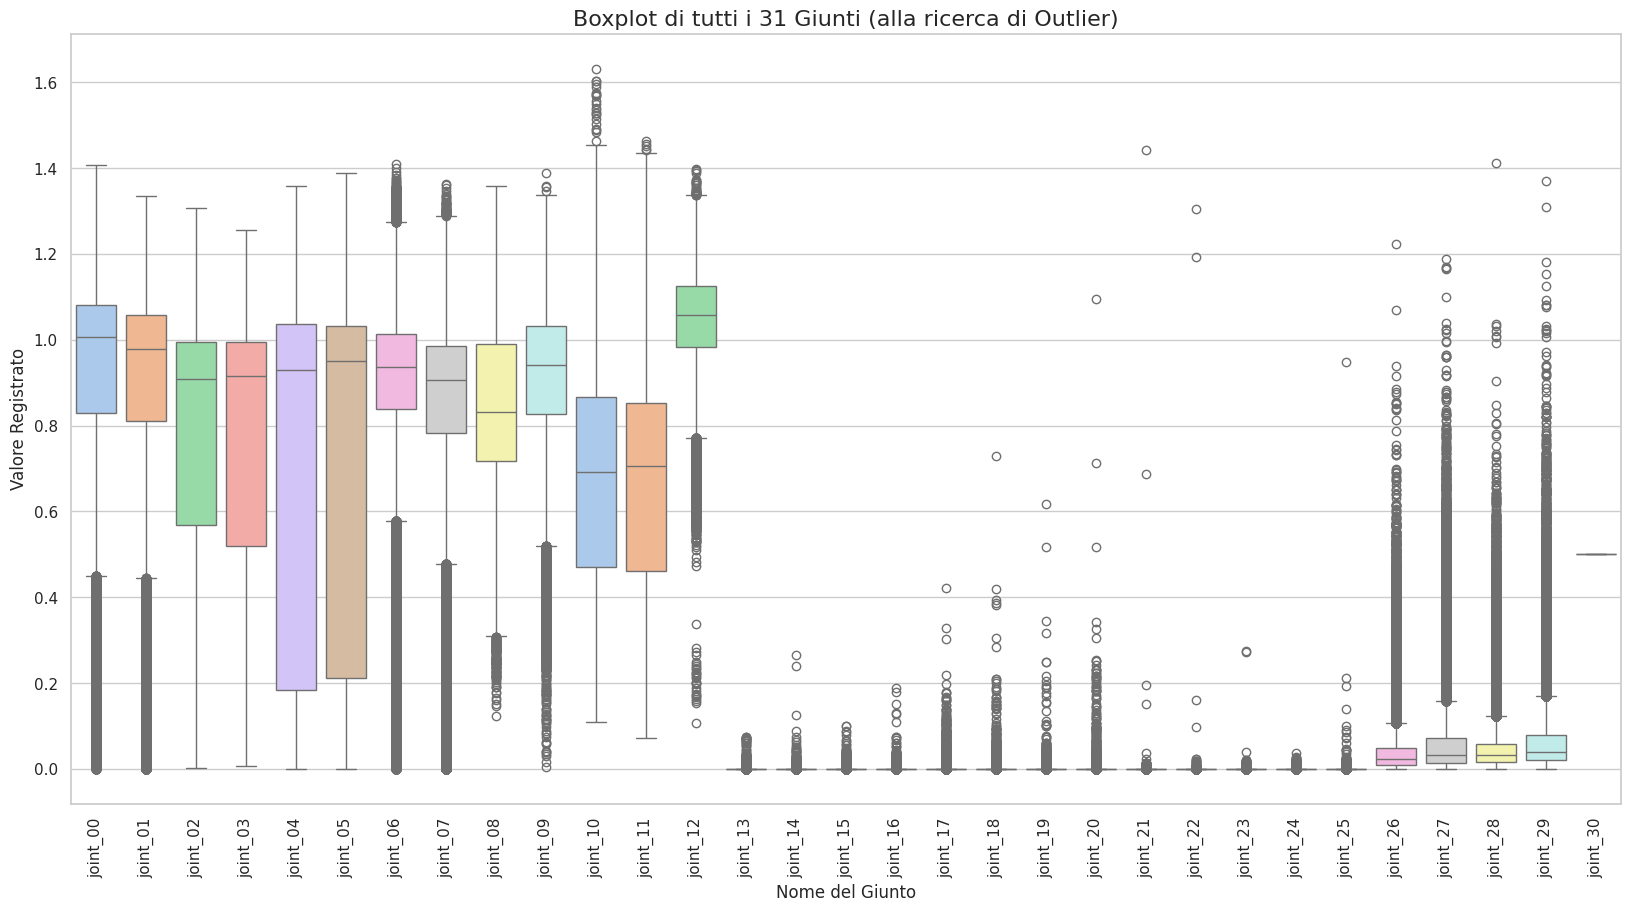


--- Analisi Boxplot ---
Si nota che 'joint_30' ha un valore costante di 0.5 e nessuna varianza (std=0).
Gli altri giunti sembrano avere scale diverse, confermando la necessità di scaling.


In [26]:
# --- Analisi Qualità Dati (NaN e Outlier) ---
if 'X_train_df' in locals():
    print("--- Analisi Qualità Dati (NaN e Outlier) ---")

    # 1. Controllo NaN (Valori Mancanti)
    # Definiamo tutte le colonne potenzialmente numeriche
    # (Assicurandoci che JOINT_COLS e SURVEY_COLS siano definite dalla Cella 2)
    all_cols_to_check = JOINT_COLS + SURVEY_COLS + ['joint_30']

    nan_check = df_features_raw[all_cols_to_check].isna().sum()
    total_nans = nan_check.sum()

    if total_nans == 0:
        print(f"RISULTATO (NaN): Eccellente. Non ci sono valori 'NaN' nel dataset.")
    else:
        print(f"ATTENZIONE: Trovati {total_nans} valori 'NaN'. Dobbiamo gestirli!")
        print(nan_check[nan_check > 0])

    # 2. Controllo Outlier (Statistiche Descrittive) ---
    print("\nAnalisi statistiche per i 31 Giunti (alla ricerca di outlier)...")
    # .describe() ci dà min, max, media, std, e i quartili
    joint_cols_all = JOINT_COLS + ['joint_30'] # Lista corretta dei 31 giunti
    joint_stats = df_features_raw[joint_cols_all].describe().transpose()

    # Stampa le statistiche
    print(joint_stats[['min', 'max', 'mean', 'std']])

    # 3. Visualizzazione (Boxplot)
    print("\nVisualizzazione della distribuzione dei Giunti (Boxplot)...")
    plt.figure(figsize=(20, 10))
    # 'Melt' trasforma il DataFrame da 'wide' a 'long' per facilitare il boxplot con seaborn

    # Correzione: JOIST_COLS -> JOINT_COLS
    melted_df = df_features_raw[joint_cols_all].melt()

    sns.boxplot(x='variable', y='value', data=melted_df, palette='pastel')
    plt.title('Boxplot di tutti i 31 Giunti (alla ricerca di Outlier)', fontsize=16)
    plt.xlabel('Nome del Giunto', fontsize=12)
    plt.ylabel('Valore Registrato', fontsize=12)
    plt.xticks(rotation=90) # Ruota i nomi dei giunti
    plt.savefig("boxplot_joints.png")
    plt.show()

    print("\n--- Analisi Boxplot ---")
    print("Si nota che 'joint_30' ha un valore costante di 0.5 e nessuna varianza (std=0).")
    print("Gli altri giunti sembrano avere scale diverse, confermando la necessità di scaling.")

else:
    print("DataFrame 'X_train_df' non trovato. Esegui prima la cella di caricamento dati.")

In [28]:
# --- Verifica Numerica 3: Feature Costante ('joint_30') ---
if 'X_train_df' in locals(): # Assicuriamoci che il train set sia già stato caricato
    print("\n--- Verifica Feature Costante ('joint_30') ---")
    joint_to_check = 'joint_30'

    # Verifica sul set di allenamento
    print("Controllo sul Training Set:")
    train_unique_values = df_features_raw[joint_to_check].unique()
    train_num_unique = df_features_raw[joint_to_check].nunique()
    print(f"  Numero di valori unici: {train_num_unique}")
    print(f"  Valori unici: {train_unique_values}")

    if train_num_unique == 1:
        print("  > CONFERMATO. Questa feature è una costante nel training set.")
    else:
        print("  > ATTENZIONE. Questa feature NON è costante nel training set.")

    # --- Caricamento e Verifica sul Test Set ---
    try:
        X_test_df = pd.read_csv('pirate_pain_test.csv')
        print("\nFile 'pirate_pain_test.csv' caricato per la verifica.")

        print("\nControllo sul Test Set:")
        test_unique_values = X_test_df[joint_to_check].unique()
        test_num_unique = X_test_df[joint_to_check].nunique()
        print(f"  Numero di valori unici: {test_num_unique}")
        print(f"  Valori unici: {test_unique_values}")

        # Verifica se è una costante e se ha lo stesso valore del training set
        if test_num_unique == 1 and np.isclose(test_unique_values[0], train_unique_values[0]):
             print(" > IMPLICAZIONE: CONFERMATO. 'joint_30' è una costante universale.")
             print("   È RUMORE e DEVE essere eliminata dal training.")
        else:
            print(" > ATTENZIONE! 'joint_30' NON è costante (o ha un valore diverso) nel test set.")

    except FileNotFoundError:
        print("\nERRORE: File 'pirate_pain_test.csv' non trovato. Impossibile verificare la coerenza.")
    except KeyError:
        print(f"\nERRORE: Colonna '{joint_to_check}' non trovata nel test set.")

else:
    print("DataFrame 'X_train_df' non trovato. Esegui prima le celle di caricamento dati.")


--- Verifica Feature Costante ('joint_30') ---
Controllo sul Training Set:
  Numero di valori unici: 1
  Valori unici: [0.5]
  > CONFERMATO. Questa feature è una costante nel training set.

File 'pirate_pain_test.csv' caricato per la verifica.

Controllo sul Test Set:
  Numero di valori unici: 1
  Valori unici: [0.5]
 > IMPLICAZIONE: CONFERMATO. 'joint_30' è una costante universale.
   È RUMORE e DEVE essere eliminata dal training.


In [30]:
# --- Verifica Numerica 2: Correlazione 'Cheat Code' (Tabelle di Contingenza) ---
if 'X_train_df' in locals() and 'y_train_df' in locals():
    print("\n--- Analisi Correlazione Feature Statiche vs. Target (Tabelle di Contingenza) ---")

    static_features_cols = ['n_legs', 'n_hands', 'n_eyes']

    # Estrazione e unione (come nella Cella 6 del tuo notebook)
    static_features_df = df_features_raw[df_features_raw['time'] == 0][['sample_index'] + STATIC_COLS]
    merged_df = static_features_df.merge(df_labels, on='sample_index')

    # Stampa Tabelle di Contingenza
    for col in static_features_cols:
        print(f"\n--- Tabella di Contingenza per '{col}' vs 'label' ---")

        # A) Conteggi Assoluti
        crosstab_abs = pd.crosstab(merged_df[col], merged_df['label'])
        print("CONTEGGI ASSOLUTI (Training Set):")
        print(crosstab_abs)

        # B) Percentuali di Riga
        # Correzione del typo qui: crosstab_perc
        crosstab_perc = pd.crosstab(merged_df[col], merged_df['label'], normalize='index')
        print(f"\nPERCENTUALI (distribuzione del dolore per '{col}'):")
        print((crosstab_perc * 100).round(1))

    print("\n--- Implicazione (Training Set) ---")
    print("Le tabelle mostrano una forte correlazione. Ad esempio, 'one+peg_leg' è quasi sempre 'no_pain'.")
    print("Questo sembra un 'cheat code'. Controlliamo se questa distribuzione vale anche nel test set.")

    # --- Verifica Coerenza Train/Test per queste feature ---
    if 'X_test_df' in locals():
        print("\n--- Verifica 2: Distribuzione Feature Statiche 'Pirata' nel Test Set ---")
        for col in static_features_cols:
            print(f"\nConteggio valori per '{col}' nel Test Set:")
            # usiamo drop_duplicates per contare ogni 'sample_id' una sola volta
            print(X_test_df.drop_duplicates(subset=['sample_index'])[col].value_counts(normalize=True) * 100)

        print("\n > IMPLICAZIONE: Le feature 'one+...' sono estremamente rare (<1%) nel test set.")
        print("   La forte correlazione vista nel training set è basata su pochi campioni (es. 6 per 'n_legs').")
        print("   Queste feature sono inaffidabili e causano overfitting. Verranno ESCLUSE.")
    else:
        print("\nTest set (X_test_df) non caricato. Impossibile verificare la coerenza.")
else:
    print("Dati di training (X_train_df o y_train_df) non caricati.")


--- Analisi Correlazione Feature Statiche vs. Target (Tabelle di Contingenza) ---

--- Tabella di Contingenza per 'n_legs' vs 'label' ---
CONTEGGI ASSOLUTI (Training Set):
label        high_pain  low_pain  no_pain
n_legs                                   
one+peg_leg          0         1        5
two                 56        93      506

PERCENTUALI (distribuzione del dolore per 'n_legs'):
label        high_pain  low_pain  no_pain
n_legs                                   
one+peg_leg        0.0      16.7     83.3
two                8.5      14.2     77.3

--- Tabella di Contingenza per 'n_hands' vs 'label' ---
CONTEGGI ASSOLUTI (Training Set):
label          high_pain  low_pain  no_pain
n_hands                                    
one+hook_hand          0         1        5
two                   56        93      506

PERCENTUALI (distribuzione del dolore per 'n_hands'):
label          high_pain  low_pain  no_pain
n_hands                                    
one+hook_hand        0.0   

In [31]:
# --- Analisi Qualità Dati sui DELTA (Passo 7 originale) ---

# Riusiamo il dataframe 'df_features_agg' dalla Cella 5, che contiene già i delta
if 'df_features_agg' in locals():
    print("\n--- Analisi Qualità Dati sui DELTA ---")

    # 1. Definizione Feature
    delta_joint_cols = [f'd_{col}' for col in JOINT_COLS]
    delta_survey_cols = [f'd_{col}' for col in SURVEY_COLS]

    # 2. Analisi Statistica dei Delta
    print("\n--- Statistiche 'Delta Giunti (30 feature)' ---")
    delta_joint_stats = df_features_agg[delta_joint_cols].describe().transpose()
    print(delta_joint_stats[['min', 'max', 'mean', 'std']])

    print("\n--- Statistiche 'Delta Pain Survey' (4 feature) ---")
    delta_survey_stats = df_features_agg[delta_survey_cols].describe().transpose()
    print(delta_survey_stats[['min', 'max', 'mean', 'std']])

    print("\n--- Implicazione ---")
    print("Confronta i 'min'/'max' dei due gruppi.")
    print("I range sono molto diversi (es. giunti ~-1.4/+1.4, survey -2/+2).")
    print(" > Conclusione: Questo supporta la decisione di trattare questi due gruppi di feature in modo diverso (es. Scaler per i giunti, Embedding per le survey).")
else:
    print("DataFrame 'df_features_agg' non è stato creato. Eseguire la cella 5.")


--- Analisi Qualità Dati sui DELTA ---

--- Statistiche 'Delta Giunti (30 feature)' ---
                 min       max          mean       std
d_joint_00 -0.266343  0.289973  3.015023e-05  0.066377
d_joint_01 -0.317609  0.270504 -9.792002e-06  0.065471
d_joint_02 -0.242639  0.253994 -1.186449e-04  0.054674
d_joint_03 -0.241012  0.240359 -5.902749e-05  0.053774
d_joint_04 -0.373067  0.225502  2.881937e-07  0.049381
d_joint_05 -0.219414  0.228815 -2.053133e-05  0.050242
d_joint_06 -0.318426  0.259580 -4.495472e-05  0.060830
d_joint_07 -0.641340  0.271581 -6.133968e-06  0.058961
d_joint_08 -0.531634  0.253846 -3.507792e-05  0.059530
d_joint_09 -0.921313  0.263405 -7.050390e-06  0.063738
d_joint_10 -0.221823  0.216016 -2.581992e-05  0.049157
d_joint_11 -0.211564  0.214572 -2.641815e-05  0.048297
d_joint_12 -0.394093  0.321661  3.094041e-05  0.073172
d_joint_13 -0.071015  0.071028 -7.009978e-08  0.000990
d_joint_14 -0.258997  0.255623 -2.235683e-07  0.001843
d_joint_15 -0.080928  0.085499 